# Lab 8

## Sampling from a Gaussian Mixture and Implementing K-Means

In [ ]:
from sklearn.datasets import make_spd_matrix
from scipy.stats import multivariate_normal
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mode
from sklearn.mixture import GaussianMixture



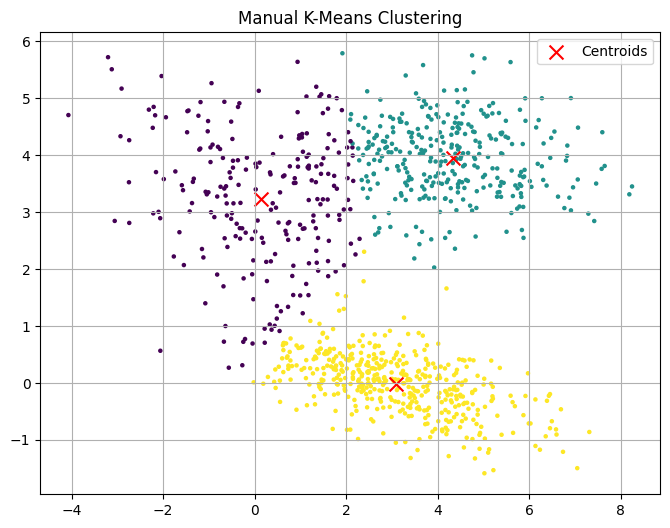

In [5]:
def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)
    U = np.random.randn(N, 2)
    return U @ A.T + m

np.random.seed(42)

Means = np.array([[0, 3], [3, 0], [4, 4]])
CovMatrices = np.zeros((3, 2, 2))
weights = np.random.rand(3)
weights = weights / np.sum(weights)

for j in range(3):
    CovMatrices[j, :, :] = make_spd_matrix(2)

nData = np.floor(weights * 1000).astype(int)
X0 = genGaussianSamples(nData[0], Means[0, :], CovMatrices[0, :, :])
X1 = genGaussianSamples(nData[1], Means[1, :], CovMatrices[1, :, :])
X2 = genGaussianSamples(nData[2], Means[2, :], CovMatrices[2, :, :])
X = np.append(np.append(X0, X1, axis=0), X2, axis=0)

K = 3
indices = np.random.choice(X.shape[0], K, replace=False)
centroids = X[indices]
labels = np.zeros(X.shape[0])

for iter in range(10):
    distance = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distance, axis=1)

    new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
    if np.all(centroids == new_centroids):
        break
    centroids = new_centroids

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Manual K-Means clustering')
plt.legend()
plt.grid(True)
plt.show()

## Visualising Gaussian Density Contours

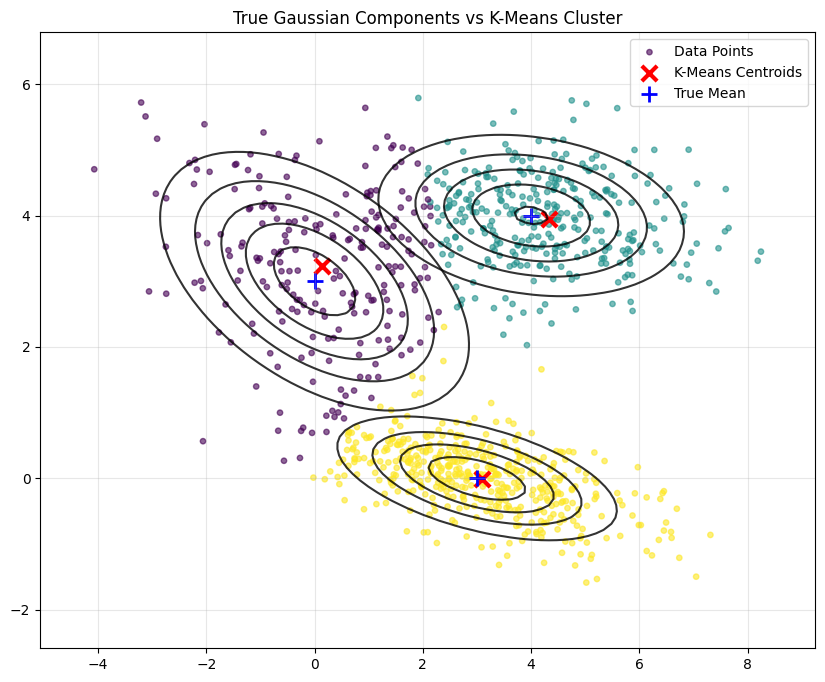

Centroids vs True Means
True Mean [0 3] : K-Means Centroid [0.12897866 3.23848011]
Distance: 0.2711
True Mean [3 0] : K-Means Centroid [ 3.08767472 -0.01073822]
Distance: 0.0883
True Mean [4 4] : K-Means Centroid [4.33379304 3.94184537]
Distance: 0.3388
Strong Agreement.


In [38]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
pos = np.dstack((xx, yy))

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=labels, s=15, cmap='viridis', alpha=0.6, label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120, linewidths=3, label='K-Means Centroids')


for j in range(3):
    z_component = multivariate_normal.pdf(pos, mean=Means[j], cov=CovMatrices[j])

    plt.contour(xx, yy, z_component, levels=5, colors='k', alpha=0.8, linewidths=1.5)

    plt.scatter(Means[j, 0], Means[j, 1], c='blue', marker='+', s=120, linewidths=2, label='True Mean' if j==0 else "")

plt.title('True Gaussian Components vs K-Means Cluster')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()


from scipy.optimize import linear_sum_assignment

distances = np.linalg.norm(Means[:, np.newaxis] - centroids, axis=2)
true_idx, kmeans_idx = linear_sum_assignment(distances)

print("Centroids vs True Means")
for t_i, k_i in zip(true_idx, kmeans_idx):
    dist = distances[t_i, k_i]
    print(f"True Mean {Means[t_i]} : K-Means Centroid {centroids[k_i]}")
    print(f"Distance: {dist:.4f}")


avg_deviation = np.mean(distances[true_idx, kmeans_idx])
if avg_deviation < 0.5:
    print("Strong Agreement.")

else:
    print("Weak")




## Comparison with sklearn

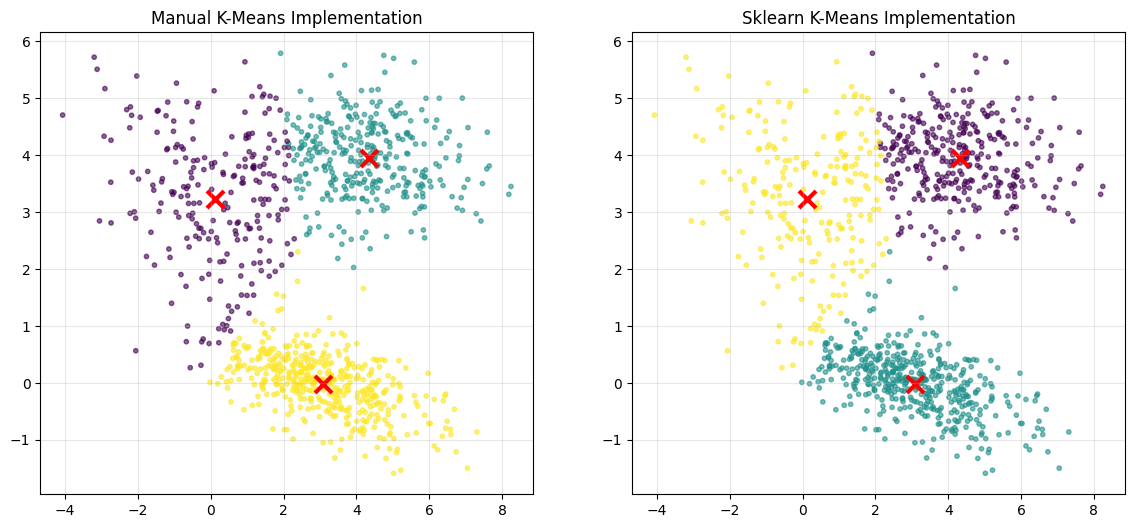

Manual Centroids:
 [[ 0.12897866 -0.01073822]
 [ 3.08767472  3.23848011]
 [ 4.33379304  3.94184537]]

Sklearn Centroids:
 [[ 0.11127009 -0.01073822]
 [ 3.08767472  3.23120686]
 [ 4.32007497  3.9426088 ]]

Sklearn Iterations: 5


In [14]:

kmeans_sklearn = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
kmeans_sklearn.fit(X)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis', alpha=0.6)
axes[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=150, linewidths=3)
axes[0].set_title('Manual K-Means Implementation')
axes[0].grid(True, alpha=0.3)


axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_sklearn.labels_, s=10, cmap='viridis', alpha=0.6)
axes[1].scatter(kmeans_sklearn.cluster_centers_[:, 0], kmeans_sklearn.cluster_centers_[:, 1], c='red', marker='x', s=150, linewidths=3)
axes[1].set_title('Sklearn K-Means Implementation')
axes[1].grid(True, alpha=0.3)

plt.show()

print("Manual:\n", np.sort(centroids, axis=0))
print("\nSklearn:\n", np.sort(kmeans_sklearn.cluster_centers_, axis=0))
print("\nSklearn Iter:", kmeans_sklearn.n_iter_)

## Sensitivity Analysis

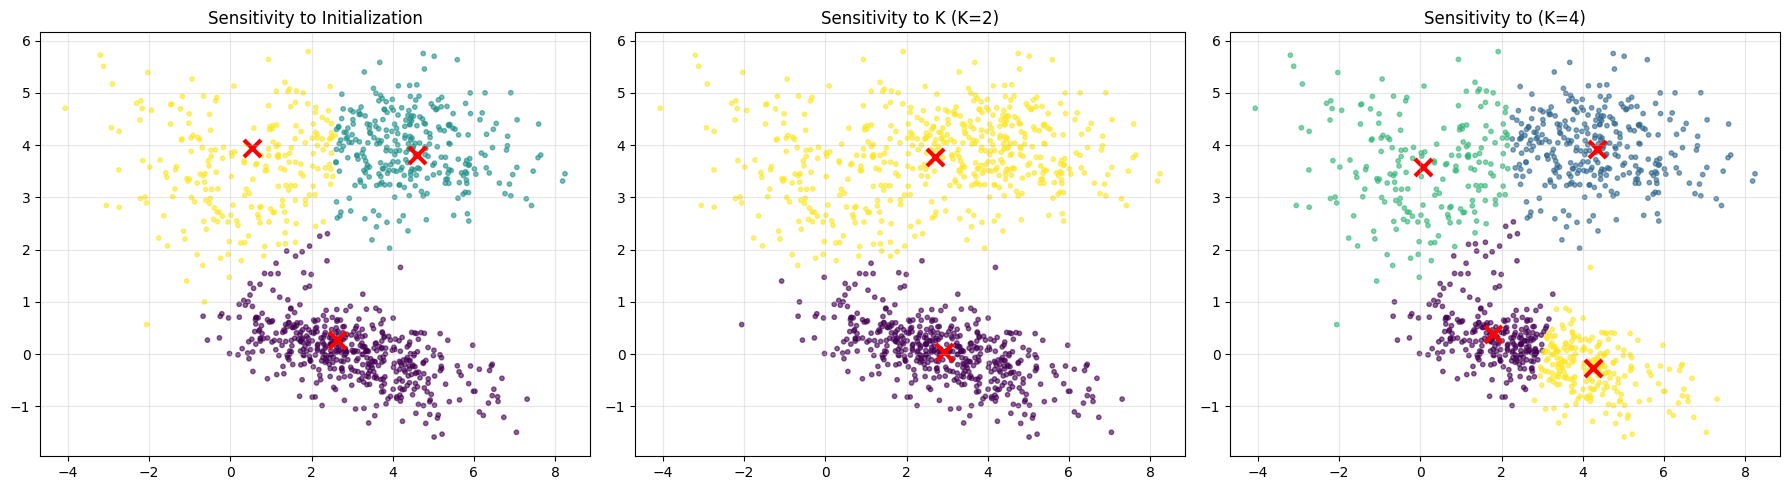

In [52]:

start_x = X[:, 0].min() + 1
start_y = X[:, 1].min() + 1

kmeans_bad_init = KMeans(
    n_clusters=3,
    init='random',
    n_init=1,
    max_iter=1,
    random_state=42
)
kmeans_bad_init.fit(X)
kmeans_bad_init.fit(X)

kmeans_under = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans_under.fit(X)

kmeans_over = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_over.fit(X)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X[:, 0], X[:, 1], c=kmeans_bad_init.labels_, s=10, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans_bad_init.cluster_centers_[:, 0], kmeans_bad_init.cluster_centers_[:, 1], c='red', marker='x', s=150, linewidths=3)
axes[0].set_title('Sensitivity to Initialization')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(X[:, 0], X[:, 1], c=kmeans_under.labels_, s=10, cmap='viridis', alpha=0.6)
axes[1].scatter(kmeans_under.cluster_centers_[:, 0], kmeans_under.cluster_centers_[:, 1], c='red', marker='x', s=150, linewidths=3)
axes[1].set_title('Sensitivity to K (K=2)')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(X[:, 0], X[:, 1], c=kmeans_over.labels_, s=10, cmap='viridis', alpha=0.6)
axes[2].scatter(kmeans_over.cluster_centers_[:, 0], kmeans_over.cluster_centers_[:, 1], c='red', marker='x', s=150, linewidths=3)
axes[2].set_title('Sensitivity to (K=4)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Application to a Real Dataset

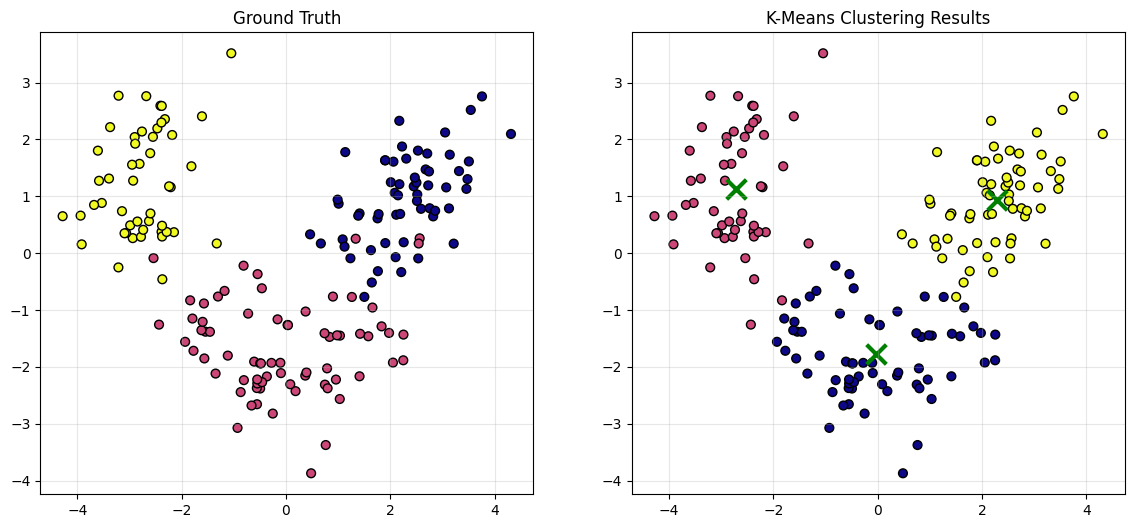

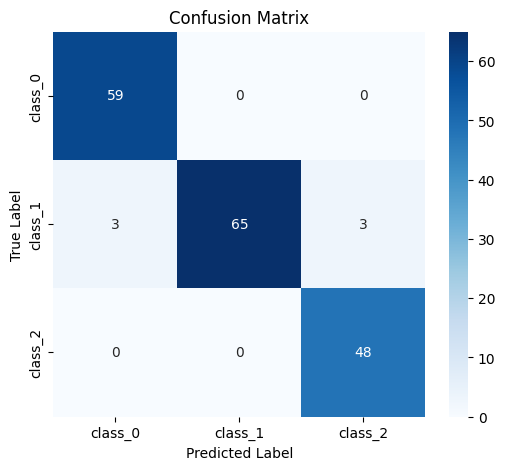

Clustering Accuracy: 0.97


In [53]:

wine = load_wine()
X_wine = wine.data
y_wine = wine.target

scaler = StandardScaler()
X_1 = scaler.fit_transform(X_wine)

kmeans_wine = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_wine.fit(X_1)
y_labels = kmeans_wine.labels_

labels_matched = np.zeros_like(y_labels)
for i in range(3):
    mask = (y_labels == i)
    if np.sum(mask) > 0:
        labels_matched[mask] = mode(y_wine[mask], keepdims=True)[0][0]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_wine, cmap='plasma', s=40, edgecolor='k')
axes[0].set_title('Ground Truth')
axes[0].grid(True, alpha=0.3)

scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_labels, cmap='plasma', s=40, edgecolor='k')
centers_pca = pca.transform(kmeans_wine.cluster_centers_)
axes[1].scatter(centers_pca[:, 0], centers_pca[:, 1], c='green', marker='x', s=200, linewidths=3)
axes[1].set_title('K-Means Clustering Results')
axes[1].grid(True, alpha=0.3)

plt.show()

cm = confusion_matrix(y_wine, labels_matched)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(f"Clustering Accuracy: {accuracy_score(y_wine, labels_matched):.2f}")



## Gaussian Mixture Model Fitting

In [54]:


def fit_and_compare_gmm(X, true_means, true_covs, true_weights, n_runs=5):
    print("True Parameters")
    print(f"Weight: {true_weights}")
    print(f"Mean: {true_means}")
    print('\n')

    for i in range(n_runs):
        seed = np.random.randint(0, 10000)
        gm = GaussianMixture(n_components=3, n_init=1, random_state=seed)
        gm.fit(X)

        distances = np.linalg.norm(true_means[:, np.newaxis] - gm.means_, axis=2)
        true_idx, pred_idx = linear_sum_assignment(distances)

        est_weights= gm.weights_[pred_idx]
        est_mean = gm.means_[pred_idx]
        est_cov = gm.covariances_[pred_idx]

        print(f"Run {i+1} :")
        print(f"Est. Weights: {est_weights}")
        print(f"Weights Difference: {np.abs(true_weights - est_weights)}")
        print(f"Means Diff : {np.linalg.norm(true_means - est_mean, axis=1)}")

        cov_diffs = [np.linalg.norm(true_covs[j] - est_cov[j], ord='fro') for j in range(3)]
        print(f"covariances Diff: {cov_diffs}")
        print('\n')

fit_and_compare_gmm(X, Means, CovMatrices, weights)

True Parameters
Weight: [0.18205878 0.46212909 0.35581214]
Mean: [[0 3]
 [3 0]
 [4 4]]


Run 1 :
Est. Weights: [0.19928469 0.46179202 0.33892329]
Weights Difference: [0.01722592 0.00033706 0.01688885]
Means Diff : [0.29348914 0.02137945 0.10038989]
covariances Diff: [np.float64(0.25499152709115097), np.float64(0.25014673377218904), np.float64(0.20203700735273483)]


Run 2 :
Est. Weights: [0.20292101 0.46224186 0.33483713]
Weights Difference: [0.02086224 0.00011278 0.02097501]
Means Diff : [0.32975996 0.02281458 0.12494052]
covariances Diff: [np.float64(0.3174296047202099), np.float64(0.25170457361995585), np.float64(0.23724329564111354)]


Run 3 :
Est. Weights: [0.19926262 0.46140187 0.33933551]
Weights Difference: [0.01720385 0.00072721 0.01647663]
Means Diff : [0.28852497 0.01995133 0.09784654]
covariances Diff: [np.float64(0.24343484893283976), np.float64(0.24769746168970283), np.float64(0.19859075369279539)]


Run 4 :
Est. Weights: [0.20085052 0.46209619 0.33705329]
Weights Differe